# Development Notebook
## 1. Classes for tank properties

* [Current Work](#WIP)

In [1]:
from dataclasses import dataclass
from typing import Union

import matplotlib.pyplot as plt
import numpy as np

In [2]:
T_d = 194  # mm
T_br = T_d / 2  # mm
T_bz = 148  # mm

E_zr1 = 50  # mm
E_zr2 = 100  # mm

In [3]:
@dataclass
class TankProperties32x2:
    T_d: int = 194
    T_r: int = 97
    T_bx: tuple = (-T_d / 2, T_d / 2)
    T_by: tuple = (-T_d / 2, T_d / 2)
    T_bz: tuple = (0, 148)
    E_zr1: int = 50
    E_zr2: int = 100
    n_el: int = 64


@dataclass
class BallAnomaly:
    x: Union[int, float]  # mm
    y: Union[int, float]  # mm
    z: Union[int, float]  # mm
    r: Union[int, float]  # mm
    perm: Union[int, float]
    material: str

In [4]:
TankProperties32x2()

TankProperties32x2(T_d=194, T_r=97, T_bx=(-97.0, 97.0), T_by=(-97.0, 97.0), T_bz=(0, 148), E_zr1=50, E_zr2=100, n_el=64)

## 2. Functions to get the hitbox

In [5]:
from src.classes import BallAnomaly, TankProperties32x2

In [6]:
tank = TankProperties32x2()
tank

TankProperties32x2(T_d=194, T_r=97, T_bx=(-97.0, 97.0), T_by=(-97.0, 97.0), T_bz=(0, 148), E_zr1=50, E_zr2=100, n_el=64)

In [7]:
ball = BallAnomaly(x=0, y=0, z=0, r=20, perm=10, material=None)
ball

BallObjectProperties(x=0, y=0, z=0, r=20, material=None)

In [8]:
@dataclass
class HitBox:
    r_min: Union[int, float]
    r_max: Union[int, float]
    x_min: Union[int, float]
    x_max: Union[int, float]
    y_min: Union[int, float]
    y_max: Union[int, float]
    z_min: Union[int, float]
    z_max: Union[int, float]

In [9]:
def compute_hitbox(
    tank: TankProperties32x2,
    ball: BallAnomaly,
    safety_tolerance: Union[int, float] = 5.0,  # mm
) -> HitBox:
    hitbox = HitBox(
        r_min=0,
        r_max=tank.T_bx[1] - ball.r - safety_tolerance,
        x_min=tank.T_bx[0] + ball.r + safety_tolerance,
        x_max=tank.T_bx[1] - ball.r - safety_tolerance,
        y_min=tank.T_by[0] + ball.r + safety_tolerance,
        y_max=tank.T_by[1] - ball.r - safety_tolerance,
        z_min=tank.T_bz[0] + ball.r + safety_tolerance,
        z_max=tank.T_bz[1] - ball.r - safety_tolerance,
    )
    return hitbox

In [10]:
compute_hitbox(tank, ball)

HitBox(r_min=0, r_max=72.0, x_min=-72.0, x_max=72.0, y_min=-72.0, y_max=72.0, z_min=25.0, z_max=123.0)

## 3. Functions for measurement steps

In [11]:
from typing import Union

import matplotlib.pyplot as plt
import numpy as np

from src.classes import BallAnomaly, HitBox, TankProperties32x2
from src.functions import compute_hitbox

In [12]:
tank = TankProperties32x2()
ball = BallAnomaly(x=0, y=0, z=0, r=20, perm=10, material=None)

In [13]:
hitbox = compute_hitbox(tank, ball)

In [14]:
hitbox.r_max = 50

In [15]:
def create_meas_coordinates(
    hitbox: HitBox, x_points: int, y_points: int, z_points: int
) -> np.ndarray:
    x = np.linspace(hitbox.x_min, hitbox.x_max, x_points)
    y = np.linspace(hitbox.y_min, hitbox.y_max, y_points)
    z = np.linspace(hitbox.z_min, hitbox.z_max, z_points)

    xx, yy, zz = np.meshgrid(x, y, z)

    distances = np.sqrt(xx**2 + yy**2)
    mask = distances <= hitbox.r_max

    x_flat = xx[mask].flatten()
    y_flat = yy[mask].flatten()
    z_flat = zz[mask].flatten()

    print(f"{x_points*y_points*z_points} measurement points were created.")
    return np.vstack((x_flat, y_flat, z_flat)).T

In [16]:
meas_coords = create_meas_coordinates(hitbox, x_points=10, y_points=10, z_points=10)

1000 measurement points were created.


## 4. Test hitbox and visualization

In [17]:
from typing import Union

import matplotlib.pyplot as plt
import numpy as np

from src.classes import BallAnomaly, HitBox, TankProperties32x2
from src.functions import compute_hitbox, create_meas_coordinates

In [18]:
tank = TankProperties32x2()
ball = BallAnomaly(x=0, y=0, z=0, r=20, perm=10, material=None)
hitbox = compute_hitbox(tank, ball)

In [19]:
print(tank)
print(ball)
print(hitbox)

TankProperties32x2(T_d=194, T_r=97, T_bx=(-97.0, 97.0), T_by=(-97.0, 97.0), T_bz=(0, 148), E_zr1=50, E_zr2=100, n_el=64)
BallObjectProperties(x=0, y=0, z=0, r=30, material=None)
HitBox(r_min=0, r_max=62.0, x_min=-62.0, x_max=62.0, y_min=-62.0, y_max=62.0, z_min=35.0, z_max=113.0)


In [21]:
meas_coords = create_meas_coordinates(hitbox, x_pts=10, y_pts=15, z_pts=10)

HitBox(x_pts,y_pts,z_pts) leads to 940 available points.
So 940 points will be measured.


In [22]:
def plot_meas_coords(
    tank: TankProperties32x2,
    meas_coords: np.ndarray,
    p_select: Union[None, int] = None,
    elev: int = 20,
    azim: int = 10,
) -> None:
    x_flat = meas_coords[:, 0]
    y_flat = meas_coords[:, 1]
    z_flat = meas_coords[:, 2]

    zyl_pnts = 50
    theta = np.linspace(0, 2 * np.pi, zyl_pnts)
    z = np.linspace(tank.T_bz[0], tank.T_bz[1], zyl_pnts)
    Z, Theta = np.meshgrid(z, theta)
    X = tank.T_r * np.cos(Theta)
    Y = tank.T_r * np.sin(Theta)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    # phantom-tank border
    ax.plot_surface(X, Y, Z, color="C7", alpha=0.2)

    if p_select == None:
        ax.scatter(x_flat, y_flat, z_flat, c="b", marker="o", alpha=0.2)
    else:
        ax.scatter(x_flat, y_flat, z_flat, c="b", marker="o", alpha=0.2)
        ax.scatter(
            meas_coords[p_select, 0],
            meas_coords[p_select, 1],
            meas_coords[p_select, 2],
            c="r",
            marker="o",
            # s=25,
        )
    ax.set_xlim([tank.T_bx[0], tank.T_bx[1]])
    ax.set_ylim([tank.T_by[0], tank.T_by[1]])
    ax.set_zlim([tank.T_bz[0], tank.T_bz[1]])

    ax.set_xlabel("x pos [mm]")
    ax.set_ylabel("y pos [mm]")
    ax.set_zlabel("z pos [mm]")
    ax.view_init(elev=elev, azim=azim)
    plt.tight_layout()
    plt.show()


def plot_meas_coords_wball(
    tank: TankProperties32x2,
    meas_coords: np.ndarray,
    ball: BallAnomaly,
    p_select: int = 0,
    elev: int = 20,
    azim: int = 10,
) -> None:
    x_flat = meas_coords[:, 0]
    y_flat = meas_coords[:, 1]
    z_flat = meas_coords[:, 2]

    zyl_pnts = 50
    theta = np.linspace(0, 2 * np.pi, zyl_pnts)
    z = np.linspace(tank.T_bz[0], tank.T_bz[1], zyl_pnts)
    Z, Theta = np.meshgrid(z, theta)
    X = tank.T_r * np.cos(Theta)
    Y = tank.T_r * np.sin(Theta)

    bwl_pts = 10
    u = np.linspace(0, 2 * np.pi, bwl_pts)
    v = np.linspace(0, np.pi, bwl_pts)
    x_c = meas_coords[p_select, 0] + ball.r * np.outer(np.cos(u), np.sin(v))
    y_c = meas_coords[p_select, 1] + ball.r * np.outer(np.sin(u), np.sin(v))
    z_c = meas_coords[p_select, 2] + ball.r * np.outer(np.ones(np.size(u)), np.cos(v))

    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    # phantom-tank border
    ax.plot_surface(X, Y, Z, color="C7", alpha=0.2)
    # selected bowl
    ax.plot_surface(x_c, y_c, z_c, color="C1", alpha=0.3)

    ax.scatter(x_flat, y_flat, z_flat, c="b", marker="o", alpha=0.1)
    ax.scatter(
        meas_coords[p_select, 0],
        meas_coords[p_select, 1],
        meas_coords[p_select, 2],
        c="r",
        marker="o",
        # s=25,
    )
    ax.set_xlim([tank.T_bx[0], tank.T_bx[1]])
    ax.set_ylim([tank.T_by[0], tank.T_by[1]])
    ax.set_zlim([tank.T_bz[0], tank.T_bz[1]])

    ax.set_xlabel("x pos [mm]")
    ax.set_ylabel("y pos [mm]")
    ax.set_zlabel("z pos [mm]")
    ax.view_init(elev=elev, azim=azim)
    plt.tight_layout()
    plt.show()

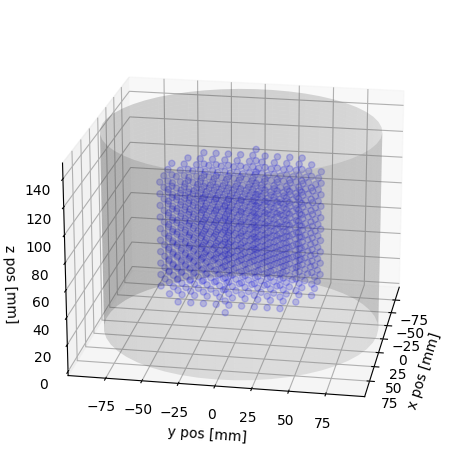

In [23]:
plot_meas_coords(tank=tank, meas_coords=meas_coords, p_select=None, elev=20, azim=10)

## 5. Testing the current state

In [1]:
from src.classes import BallAnomaly, HitBox, TankProperties32x2
from src.functions import (
    compute_hitbox,
    create_meas_coordinates,
    print_coordinates_props,
)
from src.visualization import plot_meas_coords, plot_meas_coords_wball

In [2]:
tank = TankProperties32x2()
ball = BallAnomaly(x=0, y=0, z=0, r=20, perm=10, material=None)
hitbox = compute_hitbox(tank, ball, safety_tolerance=0)

In [3]:
print(tank)
print(ball)
print(hitbox)

TankProperties32x2(T_d=194, T_r=97, T_bx=(-97.0, 97.0), T_by=(-97.0, 97.0), T_bz=(0, 148), E_zr1=50, E_zr2=100, n_el=64)
BallObjectProperties(x=0, y=0, z=0, r=20, material=None)
HitBox(r_min=0, r_max=77.0, x_min=-77.0, x_max=77.0, y_min=-77.0, y_max=77.0, z_min=20, z_max=128)


In [4]:
coordinates = create_meas_coordinates(hitbox, x_pts=20, y_pts=20, z_pts=10)

HitBox(x_pts,y_pts,z_pts) leads to 2760 available points.
So 2760 points will be measured.


In [5]:
print_coordinates_props(coordinates)

Properties of the computed coordinates
--------------------------------------
min:-68.89	max: 68.89
min:-68.89	max: 68.89
min:20.00	max: 128.00

shape (2760, 3)


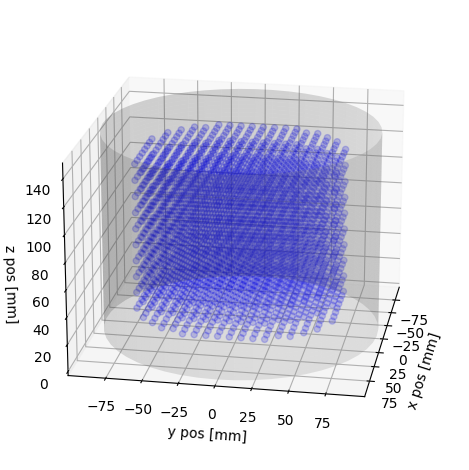

In [11]:
plot_meas_coords(tank=tank, meas_coords=coordinates, p_select=None, save_img=True)

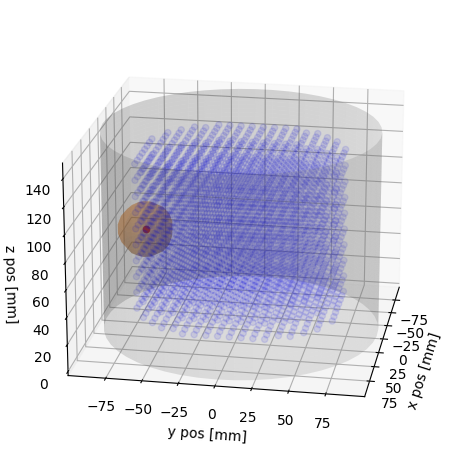

In [12]:
plot_meas_coords_wball(
    tank=tank, meas_coords=coordinates, ball=ball, p_select=34, save_img=True
)

## 6. Build IPyWidget for sliding throught the different measurement points

In [55]:
# optional

## 7. create `.json` <-> `measurement_dict` combination

In [12]:
import json
import os
from datetime import datetime

from sciopy.sciopy_dataclasses import ScioSpecMeasurementSetup

from src.classes import BallAnomaly, HitBox, TankProperties32x2
from src.functions import compute_hitbox

tank = TankProperties32x2()
ball = BallAnomaly(x=0, y=0, z=0, r=20, perm=10, material=None)
hitbox = compute_hitbox(tank, ball, safety_tolerance=0)

ssms = ScioSpecMeasurementSetup(
    burst_count=1,  # The number of measurements to be performed.
    total_meas_num=10,  # Repetitions of burst count
    n_el=64,  # Set 16, 32, 48 or 64 and do not forget to change the channel_group.
    channel_group=[
        1,
        2,
        3,
        4,
    ],  # Use [1] for n_el=16, [1,2] for n_el=32, [1,2,3] for n_el=48, and [1,2,3,4] for n_el=64
    exc_freq=10_000,  # 10,000Hz = 10kHz
    framerate=5,  # Measurements per second
    amplitude=0.01,  # 0.01A = 10mA (maximum)
    inj_skip=0,  # injection electrode skip
    gain=1,
    adc_range=1,  # +/- 1V
    notes="None",  # add measurement information
    configured=False,
)

In [51]:
def create_measurement_directory(
    meas_dir: str = "measurements/",
) -> Tuple[str, str]:
    today = datetime.now()
    f_name = today.strftime("%d_%m_%Y_%Hh_%Mm")
    s_path = f"{meas_dir}{f_name}"
    os.mkdir(s_path)
    s_path += "/"
    return s_path, f_name

In [52]:
s_path, f_name = create_measurement_directory()
print(s_path, f_name)

measurements/12_10_2023_08h_05m/ 12_10_2023_08h_05m


In [35]:
def save_parameters_to_json_file(
    s_path: str,
    ssms: ScioSpecMeasurementSetup,
    tank: TankProperties32x2,
    ball: BallAnomaly,
    hitbox: HitBox,
) -> None:
    today = datetime.now()
    ssms_dict = ssms.__dict__
    tank_dict = tank.__dict__
    ball_dict = ball.__dict__
    hitbox_dict = hitbox.__dict__

    combined_json = {
        "DateTime": today.strftime("%d.%m.%Y %H:%M"),
        "ScioSpecMeasurementSetup": ssms_dict,
        "TankProperties32x2": tank_dict,
        "BallAnomaly": ball_dict,
        "HitBox": hitbox_dict,
    }

    combined_json_str = json.dumps(combined_json, indent=4)

    with open(s_path + "info.json", "w") as file:
        file.write(combined_json_str)


# Usage
save_parameters_to_json_file(s_path, ssms, tank, ball, hitbox)

## 8. Connect Ender 5 and check the movements

In [2]:
import numpy as np
from sciopy import available_serial_ports, connect_COM_port

from src.classes import BallAnomaly, Ender5Stat, TankProperties32x2
from src.ender5 import (
    init_ender5,
    move_ender_to_coordinate,
    move_to_absolute_x_y_z,
    read_temperature,
    turn_off_fan,
    x_y_center,
)
from src.functions import compute_hitbox, create_meas_coordinates
from src.visualization import plot_meas_coords

In [2]:
tank = TankProperties32x2()
ball = BallAnomaly(x=0, y=0, z=0, r=20, perm=10, material=None)
hitbox = compute_hitbox(tank, ball, safety_tolerance=0)
enderstat = Ender5Stat(
    abs_x_pos=None,
    abs_y_pos=None,
    abs_z_pos=None,
    tank_architecture=tank,
    motion_speed=2_500,
)

In [3]:
available_serial_ports()

['COM1', 'COM4']

In [4]:
COM_Ender = connect_COM_port(port="COM4", baudrate=115200)

Connection to COM4 is established.


In [5]:
# init axis
init_ender5(COM_Ender, enderstat)

In [6]:
# validate mid position
x_y_center(COM_Ender, enderstat, print_msg=True)

b'ok\n'
Ender5Stat(abs_x_pos=180, abs_y_pos=180, abs_z_pos=0, tank_architecture=TankProperties32x2(T_d=194, T_r=97, T_bx=(-97.0, 97.0), T_by=(-97.0, 97.0), T_bz=(0, 148), E_zr1=50, E_zr2=100, n_el=64), motion_speed=2500)


In [7]:
enderstat

Ender5Stat(abs_x_pos=180, abs_y_pos=180, abs_z_pos=0, tank_architecture=TankProperties32x2(T_d=194, T_r=97, T_bx=(-97.0, 97.0), T_by=(-97.0, 97.0), T_bz=(0, 148), E_zr1=50, E_zr2=100, n_el=64), motion_speed=2500)

In [9]:
coordinates = create_meas_coordinates(hitbox, x_pts=5, y_pts=5, z_pts=5)

HitBox(x_pts,y_pts,z_pts) leads to 65 available points.
So 65 points will be measured.


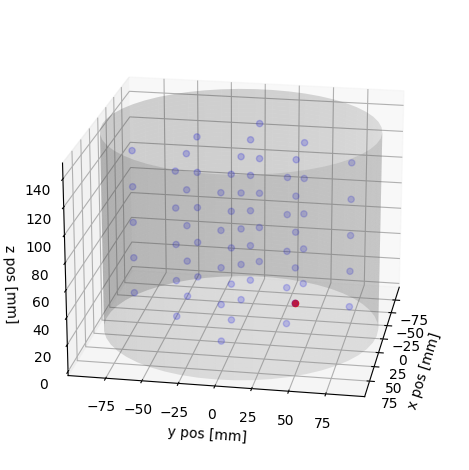

In [12]:
p_select = 50
plot_meas_coords(tank, coordinates, p_select=p_select)
coordinate = coordinates[p_select, :]

In [13]:
# move to single coordinate
move_ender_to_coordinate(COM_Ender, coordinate, enderstat, print_msg=True)

b'ok\n'
Ender5Stat(abs_x_pos=218.5, abs_y_pos=180.0, abs_z_pos=20.0, tank_architecture=TankProperties32x2(T_d=194, T_r=97, T_bx=(-97.0, 97.0), T_by=(-97.0, 97.0), T_bz=(0, 148), E_zr1=50, E_zr2=100, n_el=64), motion_speed=1500)
Ender5Stat(abs_x_pos=218.5, abs_y_pos=180.0, abs_z_pos=20.0, tank_architecture=TankProperties32x2(T_d=194, T_r=97, T_bx=(-97.0, 97.0), T_by=(-97.0, 97.0), T_bz=(0, 148), E_zr1=50, E_zr2=100, n_el=64), motion_speed=1500)


In [14]:
enderstat

Ender5Stat(abs_x_pos=218.5, abs_y_pos=180.0, abs_z_pos=20.0, tank_architecture=TankProperties32x2(T_d=194, T_r=97, T_bx=(-97.0, 97.0), T_by=(-97.0, 97.0), T_bz=(0, 148), E_zr1=50, E_zr2=100, n_el=64), motion_speed=1500)

## 9. Center Phantom Tank

In [1]:
import numpy as np
from sciopy import available_serial_ports, connect_COM_port

from src.classes import BallAnomaly, Ender5Stat, TankProperties32x2
from src.ender5 import (
    init_ender5,
    move_ender_to_coordinate,
    move_to_absolute_x_y_z,
    read_temperature,
    turn_off_fan,
    x_y_center,
    x_y_z_home,
)
from src.functions import compute_hitbox, create_meas_coordinates
from src.visualization import plot_meas_coords

In [2]:
available_serial_ports()

['COM1', 'COM4']

In [3]:
COM_Ender = connect_COM_port(port="COM4", baudrate=115200)

Connection to COM4 is established.


In [6]:
enderstat = Ender5Stat(
    abs_x_pos=None,
    abs_y_pos=None,
    abs_z_pos=None,
    tank_architecture=TankProperties32x2(),
    motion_speed=2_500,
)

In [7]:
# init axis
init_ender5(COM_Ender, enderstat)

In [8]:
?x_y_z_home

Signature:
x_y_z_home(
    ser: serial.serialwin32.Serial,
    enderstat: src.classes.Ender5Stat,
    print_msg: bool = False,
) -> None
Docstring:
Move x,y=180 and z=0.

Parameters
----------
ser : serial.serialwin32.Serial
    serial connection
enderstat : Ender5Stat
    ender 5 dataclass
print_msg : bool, optional
    print log, by default False
File:      c:\users\sciospeceit\desktop\3dit\src\ender5.py
Type:      function

In [36]:
# validate mid position
x_y_z_home(COM_Ender, enderstat, print_msg=True)

b'ok\n'
Ender5Stat(abs_x_pos=180, abs_y_pos=180, abs_z_pos=0, tank_architecture=TankProperties32x2(T_d=194, T_r=97, T_bx=(-97.0, 97.0), T_by=(-97.0, 97.0), T_bz=(0, 148), E_zr1=50, E_zr2=100, n_el=64), motion_speed=2500)


In [37]:
enderstat.abs_z_pos = 0
enderstat.abs_x_pos = 180  # -200/2
enderstat.abs_y_pos = 180  # +200/2
move_to_absolute_x_y_z(COM_Ender, enderstat, print_msg=True)

b'ok\n'
Ender5Stat(abs_x_pos=180, abs_y_pos=180, abs_z_pos=0, tank_architecture=TankProperties32x2(T_d=194, T_r=97, T_bx=(-97.0, 97.0), T_by=(-97.0, 97.0), T_bz=(0, 148), E_zr1=50, E_zr2=100, n_el=64), motion_speed=2500)


## 10. Connect Sciospec Device

In [168]:
import numpy as np
from sciopy import (
    StartStopMeasurement_usb_hs,
    SystemMessageCallback_usb_hs,
    available_serial_ports,
    connect_COM_port_usb_hs,
    del_hex_in_list,
    reshape_full_message_in_bursts,
    set_measurement_config_usb_hs,
    split_bursts_in_frames,
)
from sciopy.sciopy_dataclasses import ScioSpecMeasurementSetup

In [169]:
sciospec_measurement_setup = ScioSpecMeasurementSetup(
    burst_count=1,  # The number of measurements to be performed.
    total_meas_num=1,  # Repetitions of burst count
    n_el=64,  # Set 16, 32, 48 or 64 and do not forget to change the channel_group.
    channel_group=[
        1,
        2,
        3,
        4,
    ],  # Use [1] for n_el=16, [1,2] for n_el=32, [1,2,3] for n_el=48, and [1,2,3,4] for n_el=64
    exc_freq=10_000,  # 10,000Hz = 10kHz
    framerate=5,  # Measurements per second
    amplitude=0.01,  # 0.01A = 10mA (maximum)
    inj_skip=0,  # injection electrode skip
    gain=1,
    adc_range=1,  # +/- 1V
    notes="None",  # add measurement information
    configured=False,
)

In [170]:
COM_Sciospec = connect_COM_port_usb_hs()

In [171]:
set_measurement_config_usb_hs(COM_Sciospec, sciospec_measurement_setup)

In [221]:
# Read out system callback
SystemMessageCallback_usb_hs(COM_Sciospec, prnt_msg=True)

No message inside the message buffer


In [222]:
# Start and stop single measurement
measurement_data_hex = StartStopMeasurement_usb_hs(COM_Sciospec)

Starting measurement.
Stopping measurement.


In [223]:
len(measurement_data_hex)

35844

In [224]:
# Delete hex in mesured buffer
measurement_data = del_hex_in_list(measurement_data_hex)

# Change:
- Docstring of `reshape_full_message_in_bursts` and `split_bursts_in_frames` to:
- Doublecheck the """ syntax

In [225]:
# Reshape the full mesaurement buffer. Depending on number of electrodes
split_measurement_data = reshape_full_message_in_bursts(
    measurement_data, sciospec_measurement_setup
)

In [226]:
measurement_data = split_bursts_in_frames(
    split_measurement_data, sciospec_measurement_setup
)

In [227]:
# (burstcount, 256*SingleFrame())
# measurement_data

In [228]:
np.save("measurement_data.npy", measurement_data)

## 11. Process `measurement_data`

In [229]:
import matplotlib.pyplot as plt
import numpy as np
from sciopy.sciopy_dataclasses import ScioSpecMeasurementSetup

In [230]:
sciospec_measurement_setup = ScioSpecMeasurementSetup(
    burst_count=1,  # The number of measurements to be performed during one single measurement.
    total_meas_num=1,  # Repetitions of burst count
    n_el=64,  # Set 16, 32, 48 or 64 and do not forget to change the channel_group.
    channel_group=[
        1,
        2,
        3,
        4,
    ],  # Use [1] for n_el=16, [1,2] for n_el=32, [1,2,3] for n_el=48, and [1,2,3,4] for n_el=64
    exc_freq=10_000,  # 10,000Hz = 10kHz
    framerate=5,  # Measurements per second
    amplitude=0.01,  # 0.01A = 10mA (maximum)
    inj_skip=0,  # injection electrode skip
    gain=1,
    adc_range=1,  # +/- 1V
    notes="None",  # add measurement information
    configured=False,
)

In [231]:
tmp = np.load("measurement_data.npy", allow_pickle=True)

In [232]:
tmp.shape

(1, 256)

In [233]:
for bc in range(sciospec_measurement_setup.burst_count):
    print(tmp[bc, :].shape)

(256,)


In [234]:
single_meas = tmp[0, :]

In [235]:
def extract_potential_vals(
    single_meas: np.ndarray, ssms: ScioSpecMeasurementSetup, ret_sorted: bool = True
) -> np.ndarray:
    n_ch_el = 16  # constant, because each channel has only 16 electrodes.
    pot_matrix = np.empty((single_meas.shape[0], n_ch_el), dtype=complex)
    pot_matrix_sorted = np.empty((ssms.n_el, ssms.n_el), dtype=complex)

    for idx, single_frame in enumerate(single_meas):
        for el in range(n_ch_el):
            pot_matrix[idx, el] = single_frame.__dict__[f"ch_{el+1}"]

    pot_matrix = np.reshape(np.concatenate(pot_matrix), newshape=(ssms.n_el, ssms.n_el))
    sort_idx = [
        single_meas[i].channel_group - 1 for i in range(len(ssms.channel_group))
    ]

    for idx, s_idx in enumerate(sort_idx):
        pot_matrix_sorted[:, idx * n_ch_el : (idx + 1) * n_ch_el] = pot_matrix[
            :, s_idx * n_ch_el : (s_idx + 1) * n_ch_el
        ]
    if ret_sorted:
        return pot_matrix_sorted
    else:
        return pot_matrix

In [236]:
pot_matrix = extract_potential_vals(single_meas, sciospec_measurement_setup)

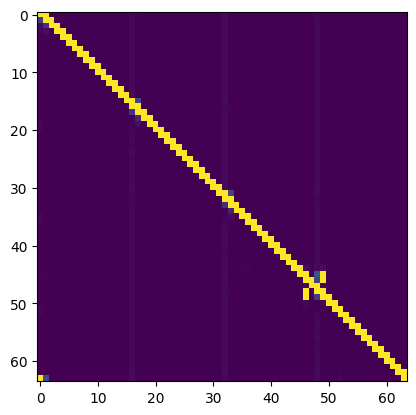

In [237]:
plt.imshow(np.abs(pot_matrix))

<a id="WIP"></a>
## 12. 3D Machine Learning

- Create a reliable 3D perm vector structure

In [1]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

from src.classes import BallAnomaly, PyEIT3DMesh, TankProperties32x2
from src.functions import compute_hitbox, create_meas_coordinates, create_mesh, set_perm
from src.visualization import plot_meas_coords, plot_meas_coords_wball, plot_mesh

In [6]:
tank = TankProperties32x2()
ball = BallAnomaly(x=0, y=0, z=50, r=20, perm=10, material=None)
hitbox = compute_hitbox(tank, ball)

In [7]:
print(tank)
print(ball)
print(hitbox)

TankProperties32x2(T_d=194, T_r=97, T_bx=(-97.0, 97.0), T_by=(-97.0, 97.0), T_bz=(0, 148), E_zr1=50, E_zr2=100, n_el=64)
BallAnomaly(x=0, y=0, z=50, r=20, perm=10, material=None)
HitBox(r_min=0, r_max=72.0, x_min=-72.0, x_max=72.0, y_min=-72.0, y_max=72.0, z_min=25.0, z_max=123.0)


In [8]:
mesh_obj = create_mesh(tank)

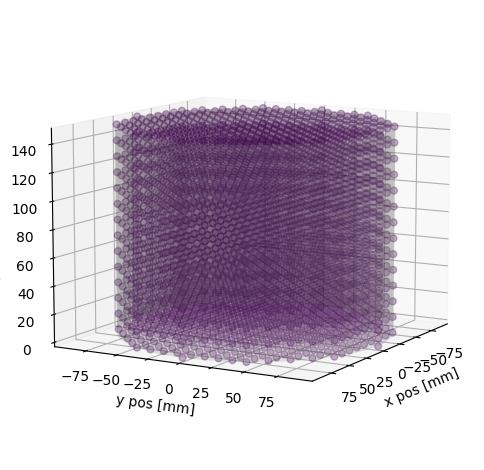

In [9]:
plot_mesh(mesh_obj, tank, show_tank_brdr=True)

In [11]:
mesh_obj = set_perm(mesh_obj, ball)

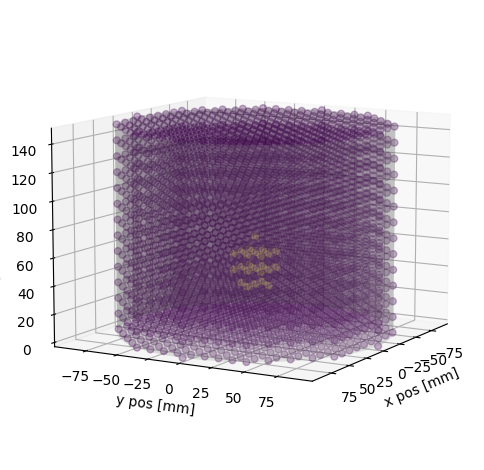

In [14]:
plot_mesh(mesh_obj, tank, show_tank_brdr=True)